In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import plotly as py
import plotly.graph_objs as go

import umap
from sklearn.preprocessing import MinMaxScaler 

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Resuming from ckpt 20

In [5]:
from ood_detection_helper import *

In [6]:
model = load_model(inlier_name="cifar10", checkpoint=-1)

(1, 32, 32, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 128)  3584        images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 32, 32, 128)  302848      conv2d[0][0]                     
                                                                 idx_sigmas[0][

In [7]:
TEST_BATCH = 1000

# @tf.function
# def preproc(x):
#     x = tf.image.grayscale_to_rgb(x)
#     x =  tf.image.pad_to_bounding_box(x, offset_height=0, offset_width=0,
#                                      target_height=32, target_width=32)
#     return x

# with tf.device('CPU'):
# #     fashion_test = get_train_test_data("fashion_mnist")[1]
# #     fashion_test = fashion_test.shuffle(10000).batch(TEST_BATCH)
# #     fashion_test = fashion_test.map(preproc)
# #     fashion_test = fashion_test.cache()

gaussian_test_batches = [tf.random.normal(shape=(TEST_BATCH, 32,32)) for i in range(10)]


In [8]:
with tf.device('CPU'):
    celeb_test = get_train_test_data("celeb_a")[1]
    celeb_test = celeb_test.shuffle(20)
celeb_test_batches = [x for x in celeb_test][:10]

In [9]:
svhn_test_batches = []
svhn_test_labels = []

with tf.device('CPU'):
    data_generators = tfds.load(name="svhn_cropped", batch_size=-1, data_dir="data", shuffle_files=True)
    svhn_test = tf.data.Dataset.from_tensor_slices(data_generators['test']).take(100)
    svhn_test = svhn_test.batch(TEST_BATCH)
    
    for x in svhn_test:
        svhn_test_batches.append(x["image"] / 255)
        svhn_test_labels.append(x["label"])

In [10]:
cifar_test_batches = []
cifar_test_labels = []

@tf.function
def normalize(x):
    return x / 255

with tf.device('CPU'):
    data_generators = tfds.load(name="cifar10", batch_size=-1, data_dir="data", shuffle_files=True)
    cifar_train = tf.data.Dataset.from_tensor_slices(data_generators['train']['image'])
    cifar_train = cifar_train.map(normalize).batch(TEST_BATCH).cache()
    cifar_test_ = tf.data.Dataset.from_tensor_slices(data_generators['test']).batch(TEST_BATCH)
    
    for x in cifar_test_:
        cifar_test_batches.append(x["image"] / 255)
        cifar_test_labels.append(x["label"])

In [11]:
len(cifar_test_batches)

10

In [12]:
LABELS = np.array(["Train", "CIFAR", "CelebA", "SVHN"])
colors = ["red", "blue", "green", "orange"]

## Generating Samples

In [13]:
@tf.function(experimental_compile=True)
def reduce_norm(x):
    return tf.norm(tf.reshape(x, shape=(x.shape[0], -1)),
                   axis=1, ord="euclidean", keepdims=True)
    

# Using all norms

In [54]:
10*10000*32*32*3*4 // 1024**3

1

In [14]:
def compute_scores(x_test):
    
    # Sigma Idx -> Score
    score_dict = []
    
    sigmas = utils.get_sigma_levels().numpy()
    final_logits = 0 #tf.zeros(logits_shape)
    progress_bar = tqdm(SIGMAS, desc='Sigma: ?')
    for idx, sigma in enumerate(progress_bar):
        
        progress_bar.set_description("Sigma: {:.4f}".format(sigma))
        _logits =[]

        for x_batch in x_test:
            idx_sigmas = tf.ones(x_batch.shape[0], dtype=tf.int32) * idx
            score = model([x_batch, idx_sigmas])
#             x_batch, y_cond = tf.split(x_batch, SPLITS, axis=-1)
#             score = tf.where(x_batch > 1e-10, score,  0)
            _logits.append(score)

        _logits = tf.concat(_logits, axis=0)
        score_dict.append(tf.identity(_logits))
        
#         final_logits += _logits * sigma
    
    return score_dict

In [15]:
outlier_datasets = (celeb_test_batches, svhn_test_batches)

In [21]:
# %%time
# train_dist = compute_scores(cifar_train)

In [16]:
%%time
cifar_dist = compute_scores(cifar_test_batches)

Sigma: 0.0100: 100%|██████████| 10/10 [03:06<00:00, 18.64s/it]

CPU times: user 59.5 s, sys: 57.4 s, total: 1min 56s
Wall time: 3min 6s


In [17]:
%%time
outlier_dists = []
progress_bar = tqdm(zip(LABELS[2:], outlier_datasets))
for name, outlier in progress_bar:
    progress_bar.set_description(name)
    outlier_dists.append(compute_scores(outlier))

CelebA: : 0it [00:00, ?it/s]
Sigma: 0.0100: 100%|██████████| 10/10 [03:18<00:00, 19.82s/it]
SVHN: : 1it [03:19, 199.04s/it]  
Sigma: 0.0100: 100%|██████████| 10/10 [03:06<00:00, 18.62s/it]
SVHN: : 2it [06:26, 193.17s/it]

CPU times: user 2min 1s, sys: 1min 51s, total: 3min 53s
Wall time: 6min 26s


In [18]:
celeb_dist, svhn_dist = outlier_dists

In [19]:
# L2-norm same as Frobenius
with tf.device("cpu"):
#     train_agg = tf.add_n([train_dist[x] * s for x, s in enumerate(SIGMAS)])
    inlier_agg = tf.add_n([cifar_dist[x] * s for x, s in enumerate(SIGMAS)])
    outlier_agg = tf.add_n([celeb_dist[x] * s for x,s in enumerate(SIGMAS)])
    outlier_agg_2 = tf.add_n([svhn_dist[x] * s for x,s in enumerate(SIGMAS)])

#     train_score = tf.reduce_mean(tf.norm(train_agg, axis=[1,2]), axis=1).numpy()[:, np.newaxis]
    cifar_score = reduce_norm(inlier_agg).numpy()
    celeb_score = reduce_norm(outlier_agg).numpy()
    svhn_score = reduce_norm(outlier_agg_2).numpy()

In [20]:
outlier_agg.shape

TensorShape([10000, 32, 32, 3])

In [21]:
df = pd.DataFrame(np.hstack((
#                 train_score[-len(cifar_score):],
                cifar_score[:TEST_BATCH*9],
                celeb_score[:TEST_BATCH*9],
                svhn_score[:TEST_BATCH*9])),
 columns=["CIFAR-Test", "CelebA", "SVHN"])
df.describe()

,CIFAR-Test,CelebA,SVHN
count,9000.000000,9000.000000,9000.000000
mean,257.300964,278.334564,289.190186
std,18.520803,10.292407,20.195919
min,177.547241,220.263855,217.087112
25%,244.826721,271.683098,275.180199
50%,256.061691,278.573837,290.008621
75%,268.087044,285.211632,303.867073
max,353.386658,321.985168,356.728851


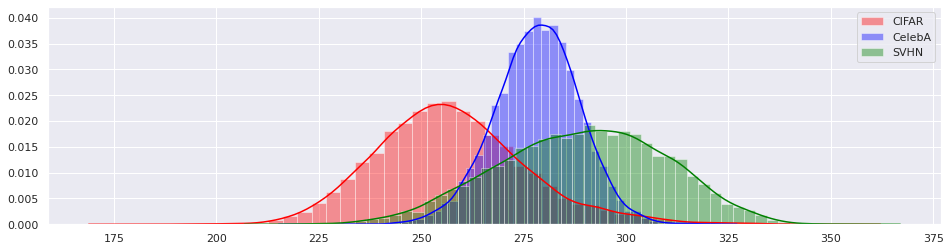

In [22]:
fig, ax = plt.subplots(1,1, figsize=(16,4))



for idx, sc in enumerate([cifar_score,
                          celeb_score,
                          svhn_score]):

    sns.distplot(sc, label=LABELS[idx+1], color=colors[idx], ax=ax)
plt.legend()
plt.show()

## Train Data = L2-norm(Pixel Scores)

In [23]:
from ood_detection_helper import *

In [39]:
with open("scores_ckpt-20.p", "rb") as f:
    score_dict = pickle.load(f)
score_dict.keys()

dict_keys(['cifar', 'celeba', 'svhn'])

In [40]:
test_data = score_dict["cifar"]
outlier_data_1 = score_dict["celeba"]
outlier_data_2 = score_dict["svhn"]

In [38]:
#### %%time
train_data, test_data = [], []
outlier_data_1, outlier_data_2 = [], [] 

for x, s in enumerate(SIGMAS):
#     train_data.append(tf.norm(fashion_train_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
    test_data.append(reduce_norm(cifar_dist[x] * s).numpy())
    outlier_data_1.append(reduce_norm(celeb_dist[x] * s).numpy())
    outlier_data_2.append(reduce_norm(svhn_dist[x] * s).numpy())
    
# train_data = np.concatenate(train_data, axis=1)
test_data = np.concatenate(test_data, axis=1)
outlier_data_1 = np.concatenate(outlier_data_1, axis=1)
outlier_data_2 = np.concatenate(outlier_data_2, axis=1)

# Shapes
shapes = [test_data.shape, outlier_data_1.shape, outlier_data_2.shape]
print(shapes)

X_train, X_test =  test_data[:9000], test_data[9000:]

# import pickle

# with open("scores_ckpt-20.p", "wb") as f:
#     pickle.dump({
#         "cifar": test_data,
#         "celeba":outlier_data_1,
#         "svhn": outlier_data_2
#     }, f)

[(10000, 10), (10000, 10), (10000, 10)]


In [27]:
# Shapes
shapes = [test_data.shape, outlier_data_1.shape, outlier_data_2.shape]

samples = np.concatenate((test_data, outlier_data_1, outlier_data_2))

labels = np.concatenate((np.zeros(test_data.shape[0]),
                         np.ones(outlier_data_1.shape[0]),
                         2*np.ones(outlier_data_2.shape[0])))

captions = np.concatenate([[LABELS[idx]]*shapes[idx-1][0] for idx in range(1,4)])

In [28]:
samples_train = np.concatenate((test_data[:9000], outlier_data_1[:9000], outlier_data_2[:9000]))
samples_test  = np.concatenate((test_data[9000:], outlier_data_1[9000:], outlier_data_2[9000:]))

samples_train.shape

(27000, 10)

## GMM

In [35]:
X_train, X_test =  test_data[:9000], test_data[9000:]
outlier_train = outlier_data_1[:9000], outlier_data_2[:9000]
outlier_test = outlier_data_1[9000:], outlier_data_2[9000:]

In [32]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score

def train_gmm_likelihood(X_train, components_range=range(2,21,2), verbose=False):
    
    
    gmm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("GMM", GaussianMixture())
    ])

    param_grid = dict(GMM__n_components = components_range,
                      GMM__covariance_type = ['full']) # Full always performs best 

    grid = GridSearchCV(estimator=gmm_clf,
                        param_grid=param_grid,
                        cv=10, n_jobs=10,
                        verbose=1)

    grid_result = grid.fit(X_train)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    if verbose:
        print("-----"*15)
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))
        plt.plot([p["GMM__n_components"] for p in params], means)

    
    best_gmm_clf = gmm_clf.set_params(**grid.best_params_)
    best_gmm_clf.fit(X_train)
    
    return best_gmm_clf

def evaluate_GMM(n):
    gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
    ]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': n})
    
    gmm_clf.fit(X_train)
    
    test_score = gmm_clf.score_samples(X_test)
    outlier_score = gmm_clf.score_samples(outlier_train[0])
    outlier_score_2 = gmm_clf.score_samples(outlier_train[1])
    
    y_true = np.concatenate((np.zeros(len(test_score)),
                             np.ones(len(outlier_score)),
                             np.ones(len(outlier_score_2))
                            ))
    
    y_scores = -np.concatenate((test_score, outlier_score, outlier_score_2))


    roc_auc = roc_auc_score(y_true,y_scores)
    
    return roc_auc

In [33]:
%time best_gmm_clf = train_gmm_likelihood(X_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   28.9s finished


Best: 1.397770 using {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
CPU times: user 3min 23s, sys: 3min 7s, total: 6min 30s
Wall time: 38.1 s


In [36]:
print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_test[0])))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_test[1])))

Training Likelihood: 1.508
CIFAR Likelihood: 1.602
CelebA Likelihood: -1.158
SVHN Likelihood: -6.825


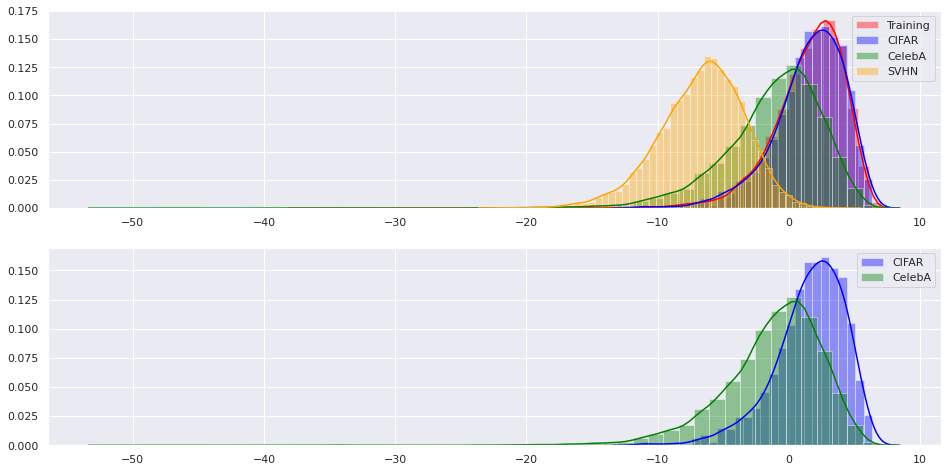

CIFAR vs SVHN
----------------
ROC-AUC: 0.9725
PR-AUC (In/Out): 0.9963 / 0.8930
FPR (95% TPR) Prec: 0.1030

CIFAR vs CelebA
----------------
ROC-AUC: 0.7394
PR-AUC (In/Out): 0.9625 / 0.2252
FPR (95% TPR) Prec: 0.7800


In [37]:
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
outlier_score = best_gmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_gmm_clf.score_samples(outlier_data_2)

evaluate_model(train_score, test_score, outlier_score, outlier_score_2, labels=LABELS)

In [43]:
# %%time


# with ThreadPoolExecutor(max_workers = 4) as exc:
#     result = list(exc.map(evaluate_GMM, component_range))

In [55]:
%%time

max_n_component = 50
component_range = range(24, max_n_component+1, 2)

result = [evaluate_GMM(n) for n in component_range]
result = np.array(result)

CPU times: user 46min 27s, sys: 1h 7min 46s, total: 1h 54min 14s
Wall time: 2min 26s


Best -> n=38: 0.837 


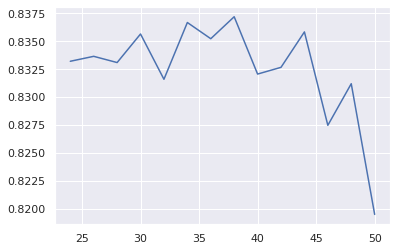

In [56]:
plt.plot(component_range, result)

print("Best -> n={}: {:.3f} ".format(component_range[np.argmax(result)], np.max(result)))

In [61]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
#     ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**{"GMM__n_components":38})

best_gmm_clf.fit(X_train)

Pipeline(steps=[('GMM', GaussianMixture(n_components=38))])

In [62]:
print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_data_1)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_data_2)))

Training Likelihood: -6.034
CIFAR Likelihood: -6.370
CelebA Likelihood: -8.289
SVHN Likelihood: -16.557


In [63]:
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
outlier_score = best_gmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_gmm_clf.score_samples(outlier_data_2)

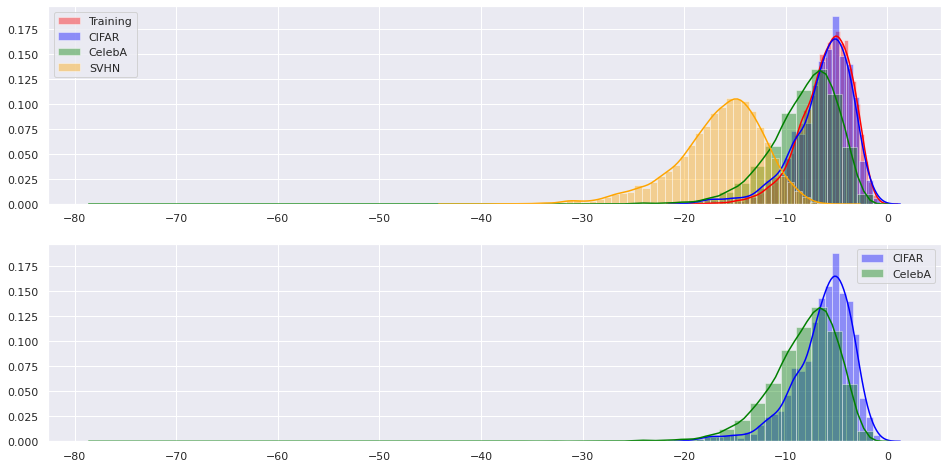

In [64]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

### AUPR-In

In [52]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9783
PR-AUC: 0.9970
Avg Prec: 0.9970


In [54]:
metrics(outlier_score_2, test_score, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9783
PR-AUC: 0.9203
Avg Prec: 0.9203


(0.9782692999999999, 0.9202829395577422, 0.92025828566857)

In [28]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(2,21,2),
                  GMM__covariance_type = ['full']) # Full always performs best 

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(X_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   25.5s finished


CPU times: user 1min 34s, sys: 1min 23s, total: 2min 58s
Wall time: 29.4 s


Best: 2.357059 using {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
---------------------------------------------------------------------------
2.041103 (0.106443) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.250167 (0.092722) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.318037 (0.101584) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.351245 (0.091468) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.349406 (0.090313) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
2.357059 (0.091248) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
2.347783 (0.098766) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
2.344918 (0.096629) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
2.333245 (0.100364) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
2.318454 (0.092045) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


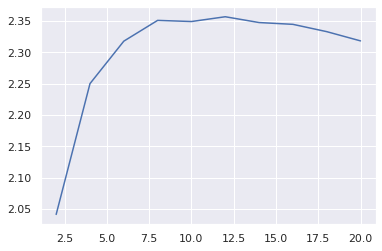

In [29]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
plt.plot([p["GMM__n_components"] for p in params], means)

In [34]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**best_params)

best_gmm_clf.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('GMM', GaussianMixture(n_components=12))])

In [35]:
print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_data_1)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_data_2)))

Training Likelihood: 2.485
CIFAR Likelihood: 2.494
CelebA Likelihood: 0.675
SVHN Likelihood: -6.140


In [36]:
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
outlier_score = best_gmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_gmm_clf.score_samples(outlier_data_2)

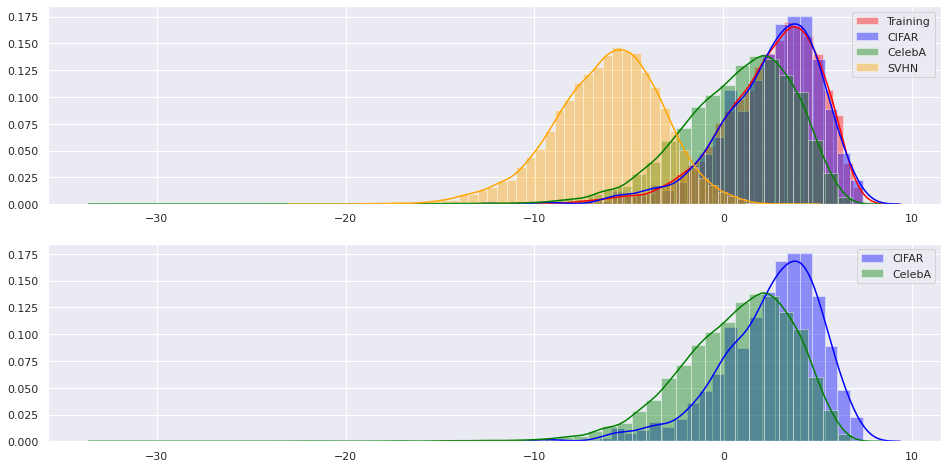

In [37]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

**CIFAR vs CelebA**

In [72]:
metrics(-test_score, -outlier_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.6519
PR-AUC: 0.9421
Avg Prec: 0.9421


**CIFAR vs SVHN**

In [81]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9706
PR-AUC: 0.9955
Avg Prec: 0.9955


### Flow Models

In [41]:
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [42]:
X_train.shape

(9000, 10)

In [43]:
scaler = StandardScaler()
s_X_train = scaler.fit_transform(X_train)

In [44]:
# Density estimation with MADE.
n = X_train.shape[0]
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[256, 256], activation="relu")

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=tfb.MaskedAutoregressiveFlow(made),
    event_shape=[10])

# Construct and fit model.
x_ = tfkl.Input(shape=(10,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adadelta(learning_rate=0.01),
              loss=lambda _, log_prob: -log_prob)

batch_size = 64
epochs = 500
history = model.fit(
    x=s_X_train,
    y=np.zeros((n, 0), dtype=np.float32),
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=n//batch_size,  # Usually `n // batch_size`.
    shuffle=True,
    verbose=True)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


Epoch 1/500
140/140 [==============================] - 0s 3ms/step - loss: 14.1345
Epoch 2/500
140/140 [==============================] - 0s 3ms/step - loss: 14.0428
Epoch 3/500
140/140 [==============================] - 0s 3ms/step - loss: 13.9719
Epoch 4/500
140/140 [==============================] - 0s 4ms/step - loss: 13.8804
Epoch 5/500
140/140 [==============================] - 0s 4ms/step - loss: 13.8116
Epoch 6/500
140/140 [==============================] - 1s 4ms/step - loss: 13.7184
Epoch 7/500
140/140 [==============================] - 1s 4ms/step - loss: 13.6472
Epoch 8/500
140/140 [==============================] - 0s 3ms/step - loss: 13.5046
Epoch 9/500
140/140 [==============================] - 0s 4ms/step - loss: 13.4108
Epoch 10/500
140/140 [==============================] - 1s 4ms/step - loss: 13.2928
Epoch 11/500
140/140 [==============================] - 0s 4ms/step - loss: 13.1568
Epoch 12/500
140/140 [==============================] - 1s 4ms/step - loss: 12.9641
E

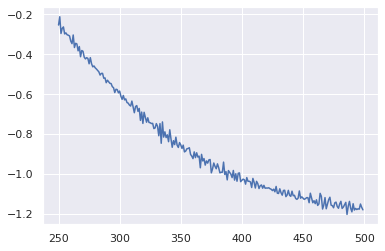

In [45]:
start_idx=250
plt.plot(range(start_idx, epochs), history.history["loss"][start_idx:])
# plt.yscale("log")

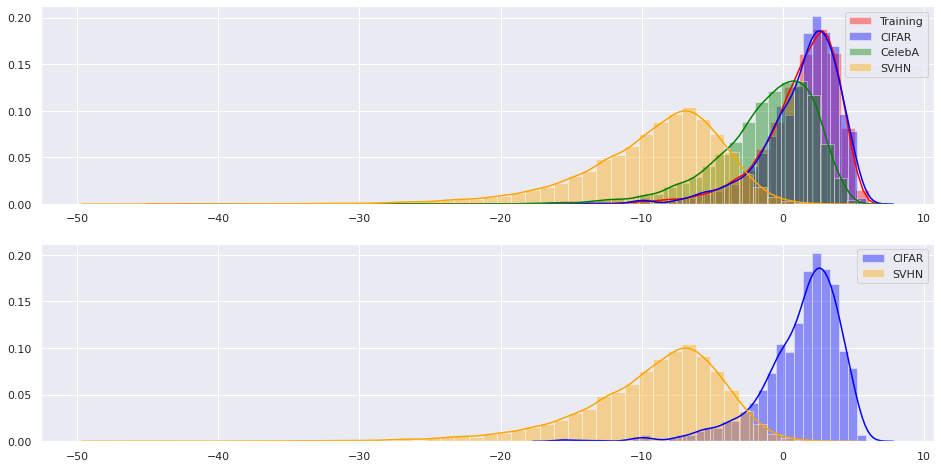

CPU times: user 1.5 s, sys: 83.1 ms, total: 1.58 s
Wall time: 1.58 s


In [46]:
%%time
train_score = distribution.log_prob(scaler.transform(X_train), dtype=np.float32).numpy()
test_score = distribution.log_prob(scaler.transform(X_test), dtype=np.float32).numpy()
outlier_score = distribution.log_prob(scaler.transform(outlier_data_1), dtype=np.float32).numpy()
outlier_score_2 = distribution.log_prob(scaler.transform(outlier_data_2), dtype=np.float32).numpy()

fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

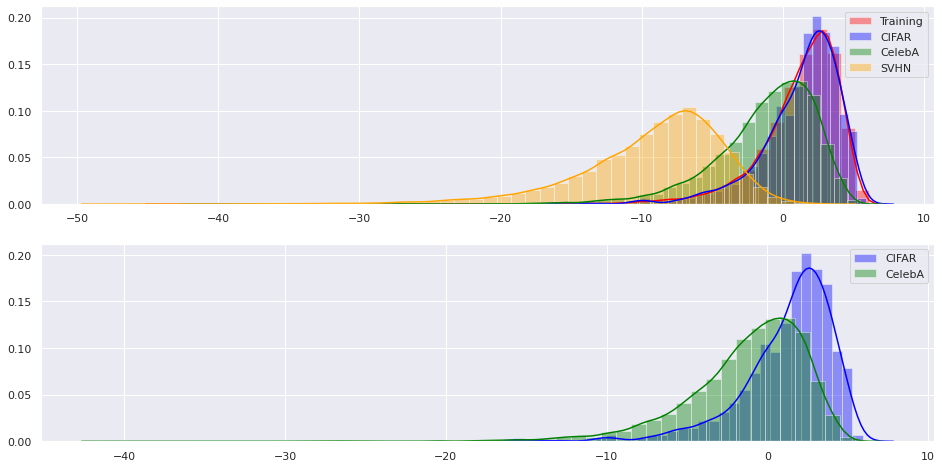

CIFAR vs SVHN
----------------
ROC-AUC: 0.9764
PR-AUC (In/Out): 0.9967 / 0.9158
FPR (95% TPR) Prec: 0.0840

CIFAR vs CelebA
----------------
ROC-AUC: 0.7343
PR-AUC (In/Out): 0.9583 / 0.2735
FPR (95% TPR) Prec: 0.7430


In [47]:
evaluate_model(train_score, test_score, outlier_score, outlier_score_2, labels=LABELS)

In [89]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)
metrics(outlier_score_2[0:-1:10], test_score, plot=False, verbose=True)

Inlier vs Outlier
----------------
ROC-AUC: 0.9736
PR-AUC: 0.9957
Avg Prec: 0.9957
Inlier vs Outlier
----------------
ROC-AUC: 0.9731
PR-AUC: 0.9799
Avg Prec: 0.9799


(0.9730880000000001, 0.9798725853760307, 0.9798645706499773)

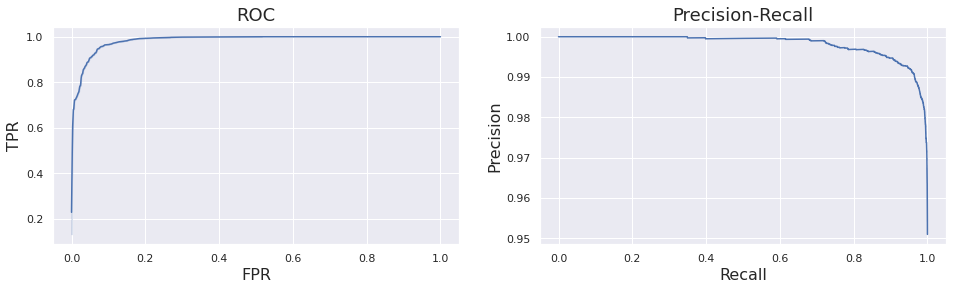

Inlier vs Outlier
----------------
ROC-AUC: 0.9840
PR-AUC: 0.9982
Avg Prec: 0.9982


In [76]:
metrics(-test_score, -outlier_score_2, plot=True, verbose=True)
plt.show()

## GMM on Embeddings

In [106]:
%%time
X_train_embedding = reducer.transform(X_train)
X_test_embedding = reducer.transform(X_test)
outlier_1_embedding = reducer.transform(outlier_data_1[9000:])
outlier_2_embedding = reducer.transform(outlier_data_2[9000:])

CPU times: user 9.6 s, sys: 340 ms, total: 9.94 s
Wall time: 9.82 s


In [155]:
outlier_train_embedding_1 = reducer.transform(outlier_data_1[:9000])
outlier_train_embedding_2 = reducer.transform(outlier_data_2[:9000])

In [107]:
X_train, X_test =  test_data[:9000], test_data[9000:]

In [131]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(20,101,10),
                  GMM__covariance_type = ['full']) # Full always performs best 

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(X_train_embedding)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:   38.6s finished


CPU times: user 59.3 s, sys: 8.16 s, total: 1min 7s
Wall time: 43.4 s


Best: -2.327967 using {'GMM__covariance_type': 'full', 'GMM__n_components': 100}
---------------------------------------------------------------------------
-2.662801 (0.046925) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
-2.573499 (0.042412) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 30}
-2.506286 (0.047969) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 40}
-2.454949 (0.040034) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 50}
-2.428373 (0.039311) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 60}
-2.401051 (0.052309) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 70}
-2.368396 (0.039467) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 80}
-2.348367 (0.041998) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 90}
-2.327967 (0.038845) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 100}


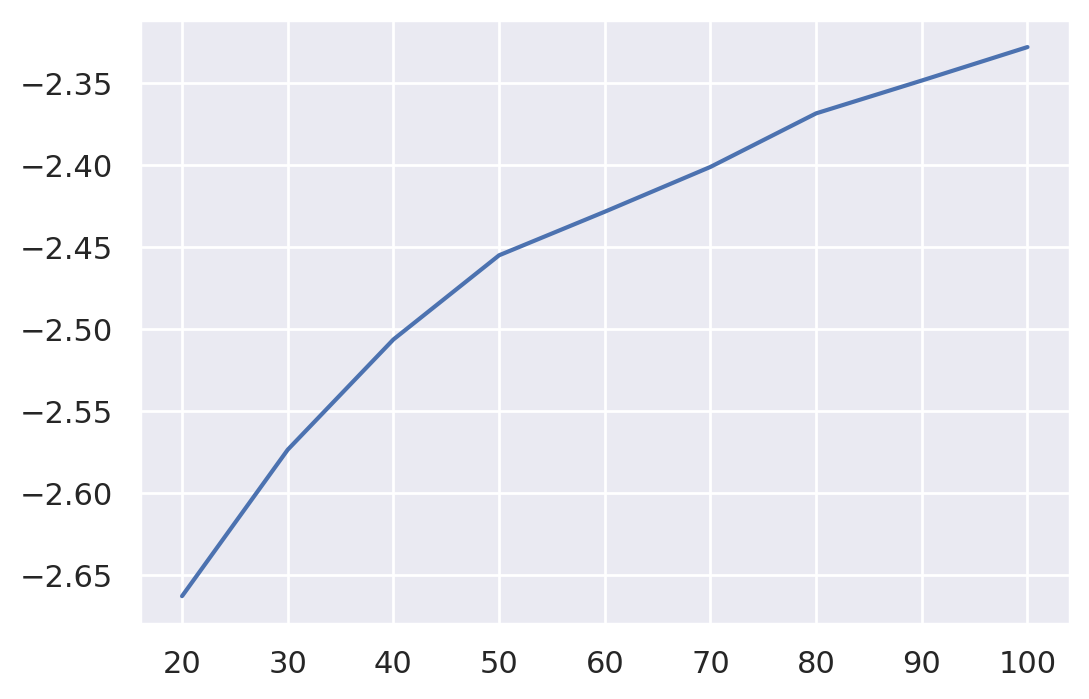

In [135]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
plt.plot([p["GMM__n_components"] for p in params], means)

In [143]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': 20})

best_gmm_clf.fit(X_train_embedding)

print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[1], best_gmm_clf.score(X_test_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[2], best_gmm_clf.score(outlier_1_embedding)))
print("{} Likelihood: {:.3f}".format(LABELS[3], best_gmm_clf.score(outlier_2_embedding)))

Training Likelihood: -2.651
CIFAR Likelihood: -2.703
CelebA Likelihood: -4.148
SVHN Likelihood: -21.181


In [ ]:
Training Likelihood: -2.535
CIFAR Likelihood: -2.615
CelebA Likelihood: -4.136
SVHN Likelihood: -21.257

In [144]:
train_score = best_gmm_clf.score_samples(X_train_embedding)
test_score = best_gmm_clf.score_samples(X_test_embedding)
outlier_score = best_gmm_clf.score_samples(outlier_1_embedding)
outlier_score_2 = best_gmm_clf.score_samples(outlier_2_embedding)

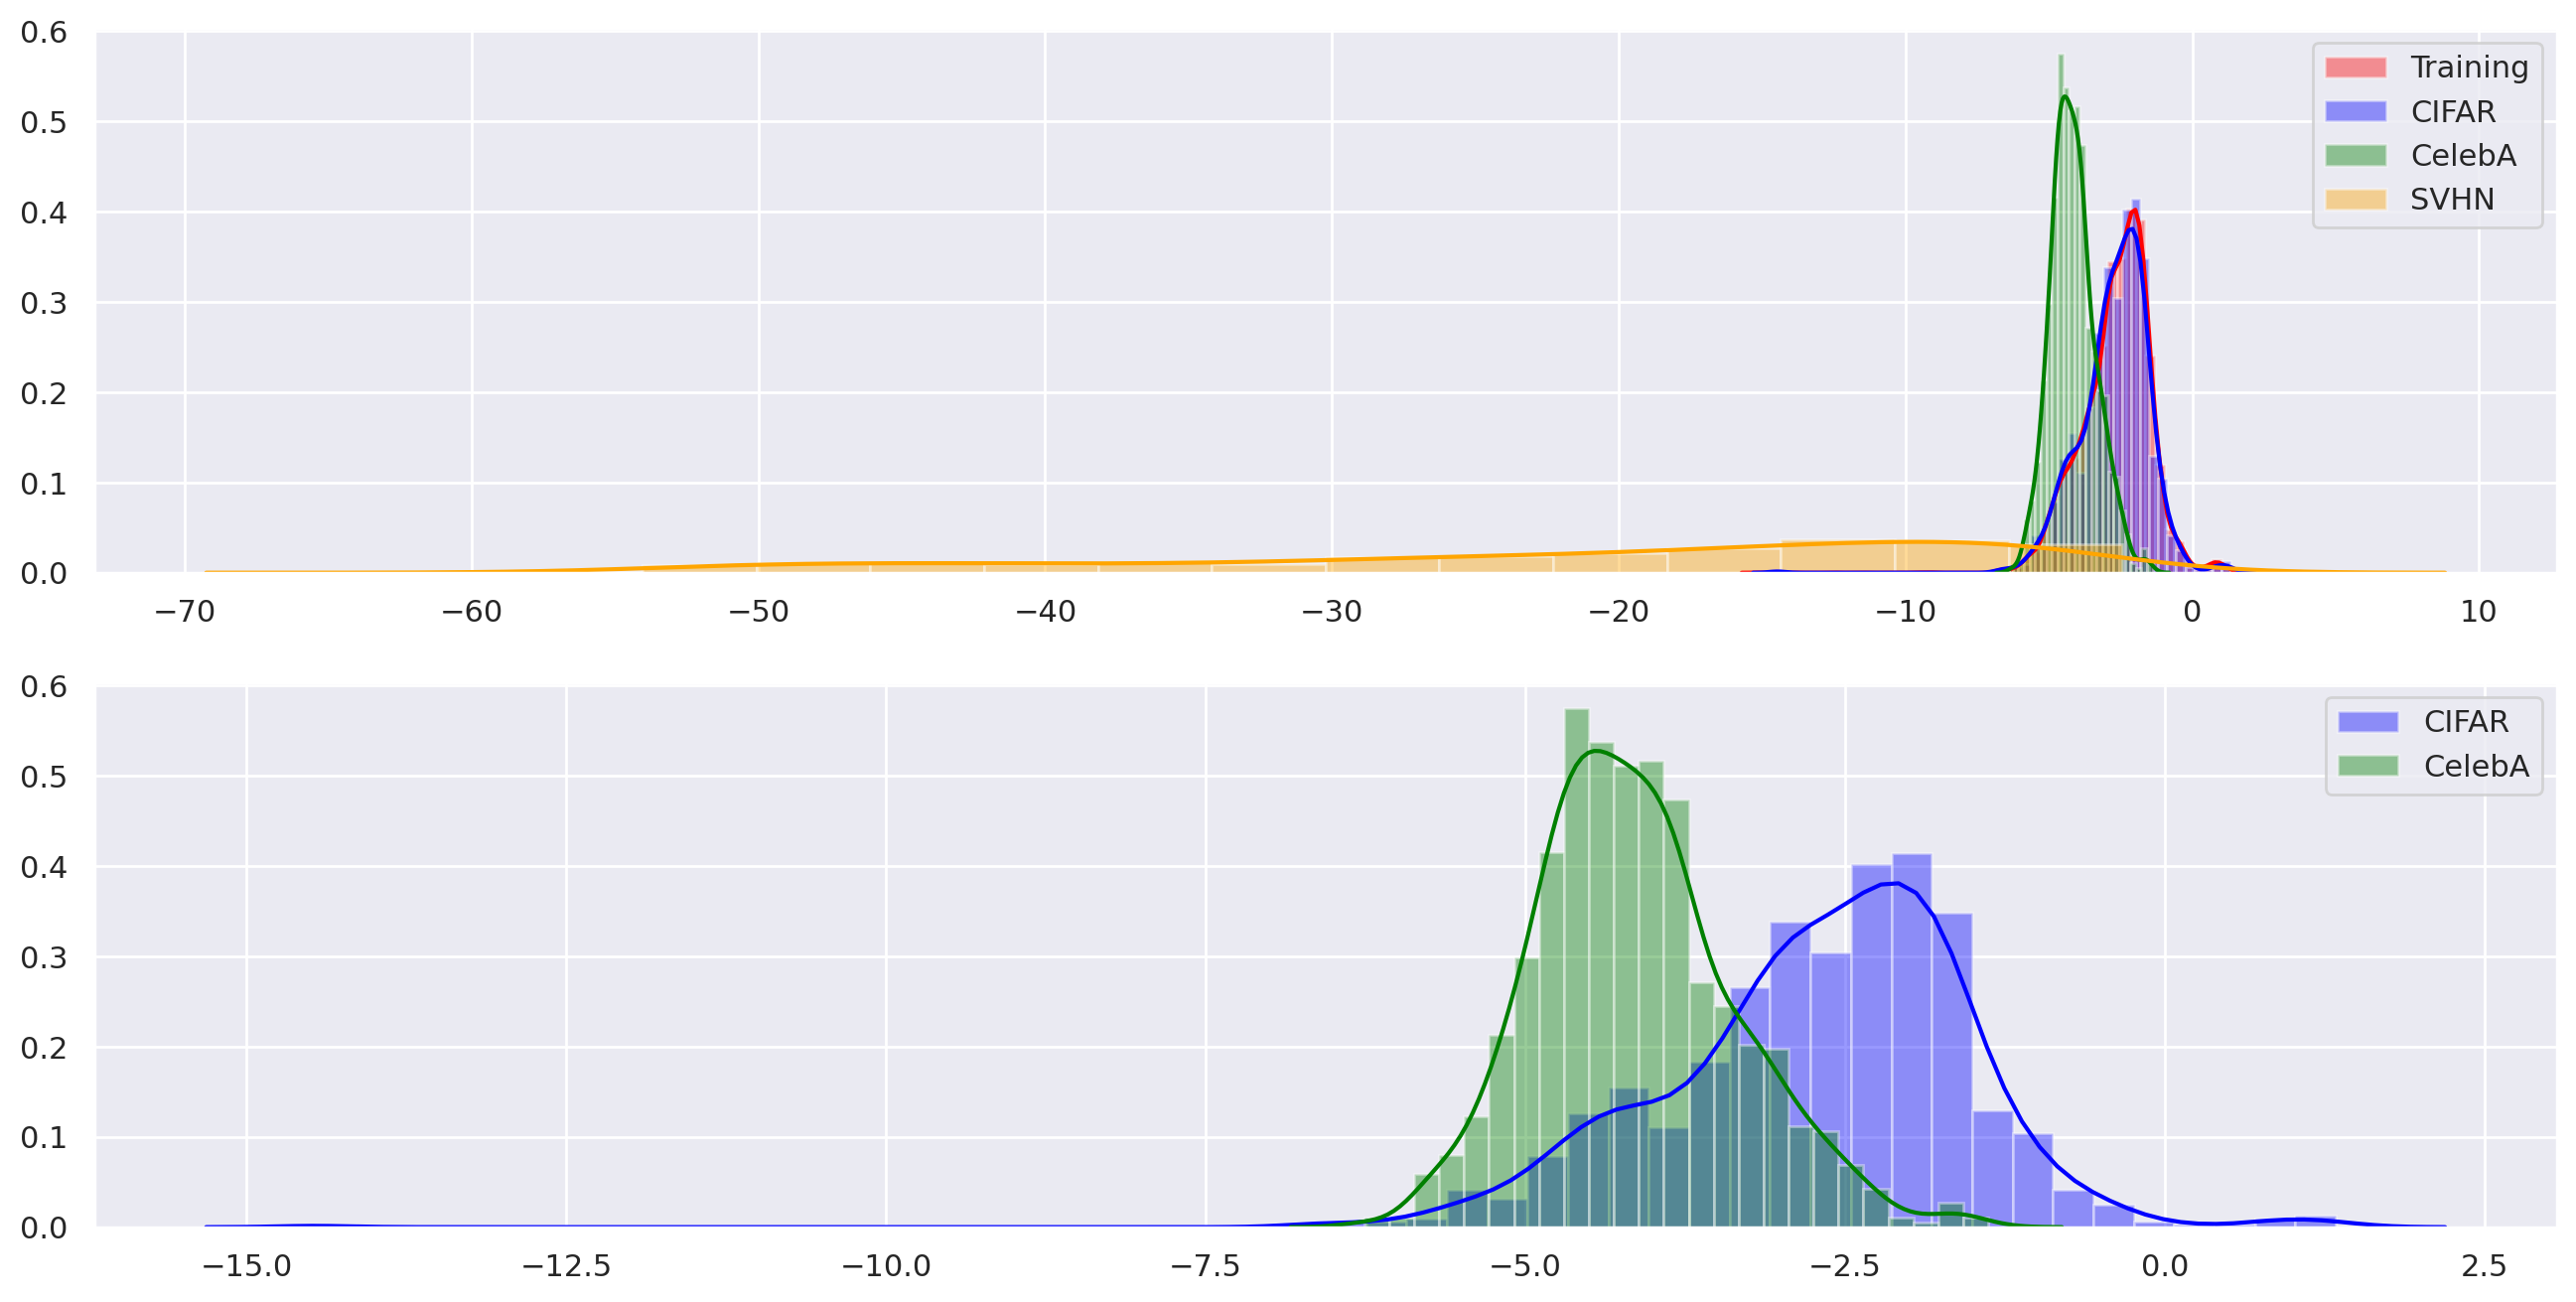

In [145]:
fig, axs = plt.subplots(2,1, figsize=(16,8))

sns.distplot(train_score,color=colors[0], label="Training", ax=axs[0])
sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[0])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[0])
sns.distplot(outlier_score_2, color=colors[3], label=LABELS[3], ax=axs[0])

sns.distplot(test_score, color=colors[1], label=LABELS[1], ax=axs[1])
sns.distplot(outlier_score, color=colors[2], label=LABELS[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score

def evaluate_GMM_emb(n):
    gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
    ]).set_params(**{'GMM__covariance_type': 'full', 'GMM__n_components': n})
    
    gmm_clf.fit(X_train_embedding)
    
    test_score = gmm_clf.score_samples(X_test_embedding)
    outlier_score = gmm_clf.score_samples(outlier_train_embedding_1)
    outlier_score_2 = gmm_clf.score_samples(outlier_train_embedding_2)
    
    y_true = np.concatenate((np.zeros(len(test_score)),
                             np.ones(len(outlier_score)),
                             np.ones(len(outlier_score_2))
                            ))
    
    y_scores = -np.concatenate((test_score, outlier_score, outlier_score_2))


    roc_auc = roc_auc_score(y_true,y_scores)
    
    return roc_auc

In [ ]:
%%time

max_n_component = 25
component_range = range(1, max_n_component+1, 1)

with ThreadPoolExecutor(max_workers = 4) as exc:
    result = list(exc.map(evaluate_GMM, component_range))
    
result = np.array(result)

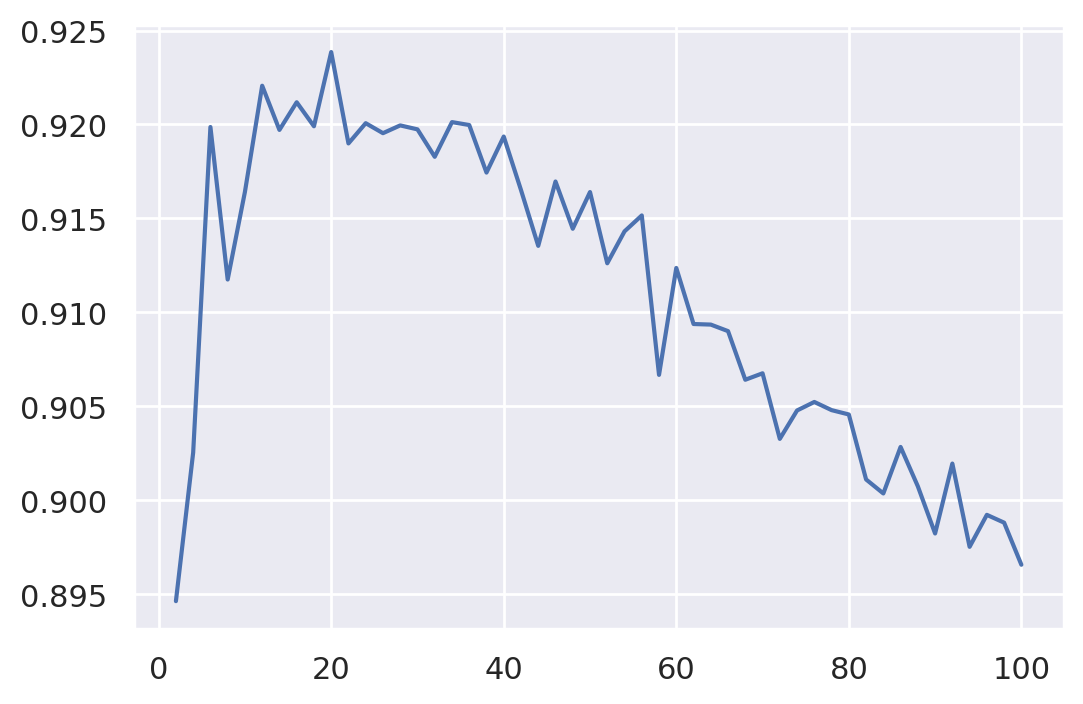

In [166]:
plt.plot(component_range, result)

print("Best -> {}:{:.3f} ".format(component_range[np.argmax(result)], np.max(result)))

In [ ]:
y_true = np.concatenate((np.zeros(len(inlier_score)),
                         np.ones(len(outlier_score))))
y_scores = np.concatenate((inlier_score, outlier_score))


roc_auc = roc_auc_score(y_true,y_scores)

In [151]:
metrics(-test_score, -np.concatenate((outlier_score, outlier_score_2)), plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9197
PR-AUC: 0.9564
Avg Prec: 0.9564


**CIFAR vs CelebA**

In [146]:
metrics(-test_score, -outlier_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.8493
PR-AUC: 0.7716
Avg Prec: 0.7724


**CIFAR vs SVHN**

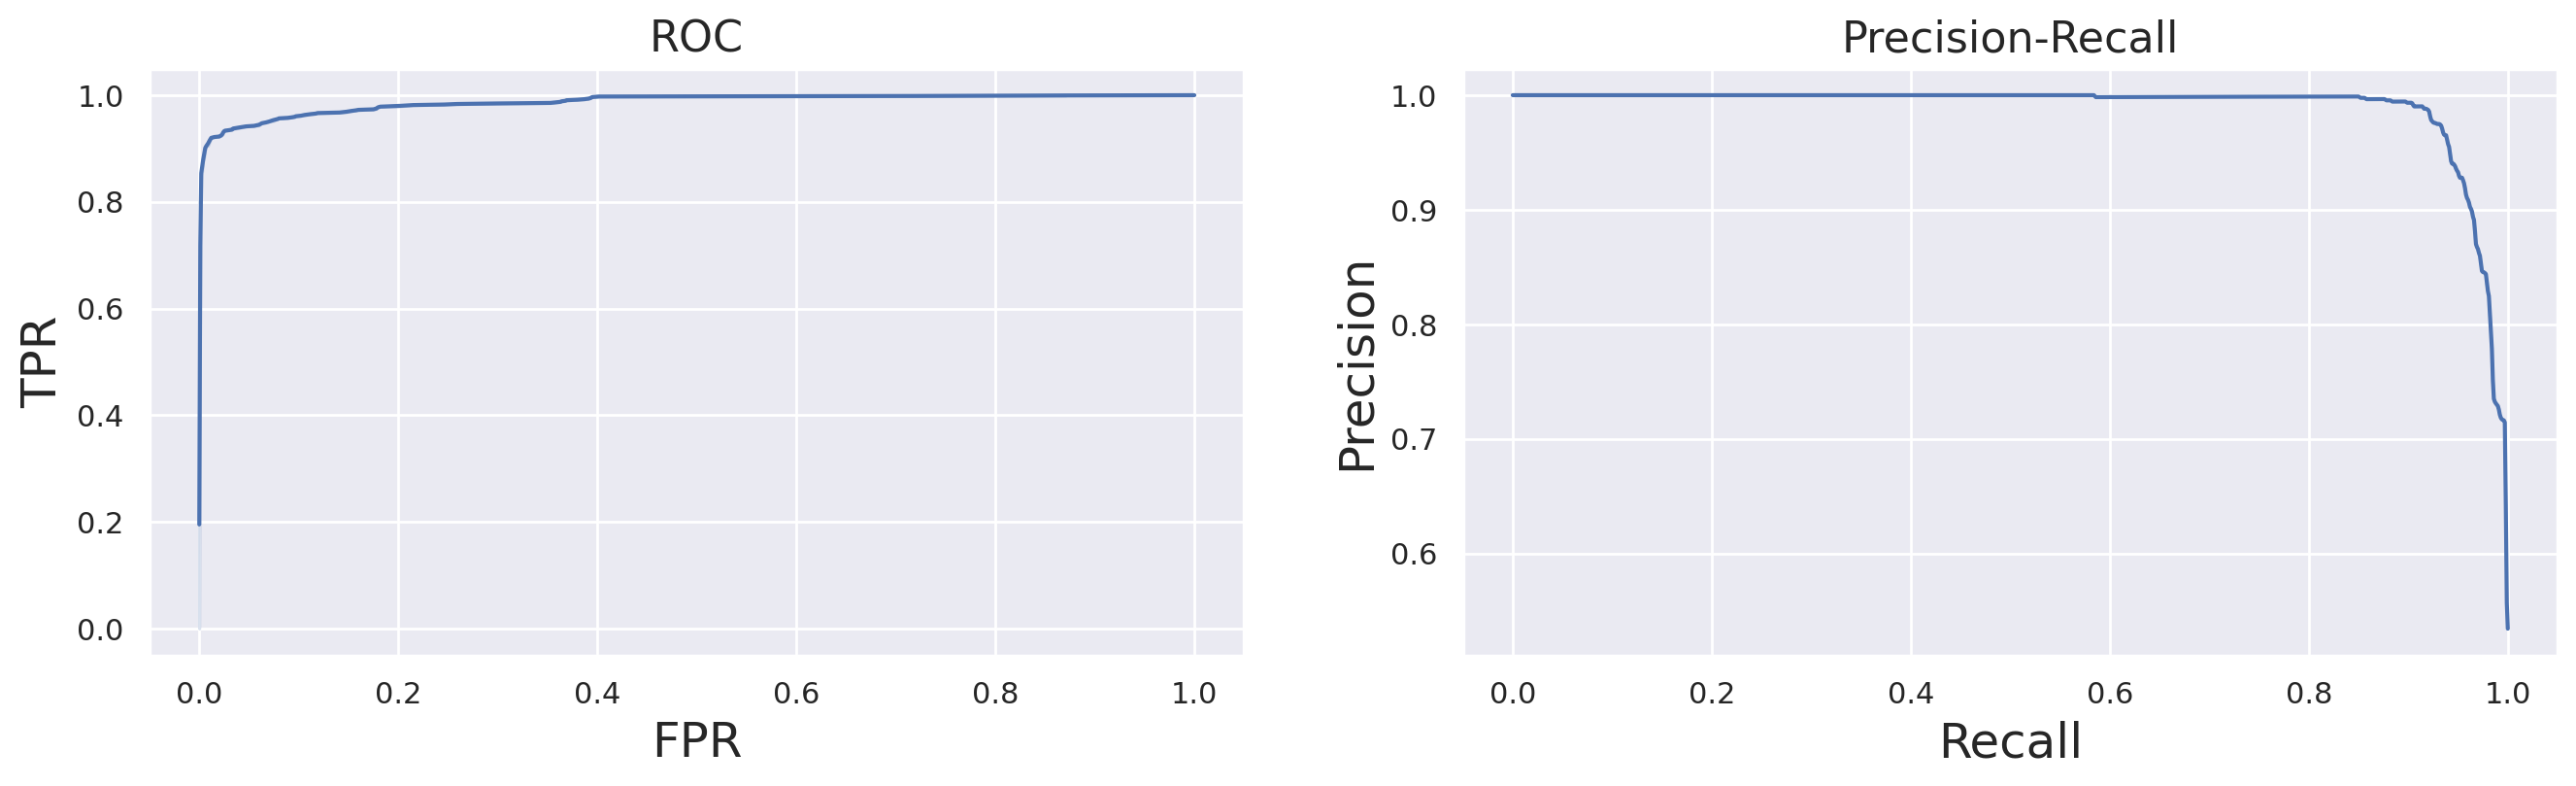

Inlier vs Outlier
----------------
ROC-AUC: 0.9868
PR-AUC: 0.9893
Avg Prec: 0.9893


In [119]:
metrics(-test_score, -outlier_score_2, plot=True, verbose=True)
plt.show()